In [2]:
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import os

from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
from imblearn.metrics import sensitivity_score, specificity_score

## Utils

In [3]:
# folder = "CK+"
folder = "images/train"
expressions = os.listdir(folder)
sizes = [48, 128, 224]
if 'contempt' in expressions:
    expressions.remove('contempt')
print(expressions)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [4]:
class_id = {}
id_class = {}
cont = 0
for expression in expressions:
    class_id[expression] = cont
    id_class[cont] = expression
    cont += 1
print(class_id)
print(id_class)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [5]:
suma = 0
for expression in expressions:
    path = folder+"/"+expression
    images = os.listdir(path)
    print(expression, len(images))
    suma += len(images)
    id_class[len(images)] = expression
print("Total: ", suma)

angry 3993
disgust 436
fear 4103
happy 7164
neutral 4982
sad 4938
surprise 3205
Total:  28821


In [6]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# list_img_48 = [[[[]]]]
list_img_128 = [[[[]]]]
list_img_224 = [[[[]]]]
y = []

for expression in expressions:
    path = folder+"/"+expression
    images = os.listdir(path)
    print(expression)
    for i in range(len(images)):
        image = images[i]
        img = cv2.imread(path+"/"+image)

        # COMENTAR ESTE BLOQUE EN CASO DE CORRER EL PRIMER DATASET
        if i == 200:
            break
        cropped_image = img
        # FIN DEL COMENTARIO
        
        # COMENTAR ESTE BLOQUE EN CASO DE CORRER EL SEGUNDO DATASET
        # grayscale_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # column, row, width, height = face_cascade.detectMultiScale(grayscale_image)[0]
        # cropped_image = img[row:(row+height), column:(column+width)]
        # FIN DEL COMENTARIO

        # resize_img = cv2.resize(cropped_image, (sizes[0], sizes[0]))
        # if len(list_img_48[0][0][0]) == 0:
        #     list_img_48[0] = resize_img
        # else:
        #     list_img_48.append(resize_img)

        resize_img = cv2.resize(cropped_image, (sizes[1], sizes[1]))
        if len(list_img_128[0][0][0]) == 0:
            list_img_128[0] = resize_img
        else:
            list_img_128.append(resize_img)

        resize_img = cv2.resize(cropped_image, (sizes[2], sizes[2]))
        if len(list_img_224[0][0][0]) == 0:
            list_img_224[0] = resize_img
        else:
            list_img_224.append(resize_img)

        y.append(class_id[expression])
    # print(len(y), len(list_img_224))

angry
disgust
fear
happy
neutral
sad
surprise


In [25]:
class MyDataset(Dataset):
    def __init__(self, list_IDs, labels):
        self.labels = labels
        self.list_IDs = list_IDs

    def __len__(self):
        return len(self.list_IDs)

    def __getitem__(self, index):
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        preprocess = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                # transforms.CenterCrop(224)
                # transforms.RandomHorizontalFlip()
        ])
        X = preprocess(Image.fromarray(ID))
        y = self.labels[index]
        return X, y

In [8]:
def train(model, optimizer, loss_fn, num_epochs):
  # train the model
  list_loss_train = []
  list_loss_test = []

  beg = time.time()
  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)
      # forward 
      output = model(images)
      loss   = loss_fn(output, labels)
      # change the params
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    list_loss_train.append(loss.item())

    print ('Epoch [{}/{}], Loss: {:.4f}' 
          .format(epoch+1, num_epochs, loss.item()))
    
  end = time.time()
  print('Finished training trainset in {} seconds'.format(round(end-beg, 2)))

  return list_loss_train

In [9]:
def test(model):
    with torch.no_grad():
        correct: int = 0
        total: int = 0
        y_pred: list = []
        y_test: list = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pred.extend((predicted).tolist())
            y_test.extend((labels).tolist())
        accuracy: float = 100*correct/total
        matrix = confusion_matrix(y_test, y_pred)
        df = pd.DataFrame(matrix, index=expressions, columns=expressions)
        sns.heatmap(df, annot=True, cbar=None, cmap="Greens")
        plt.title("Confusion Matrix"), plt.tight_layout()
        plt.xlabel("Predicted")
        plt.ylabel("Real")
        plt.show()
        print("Sensitivity")
        print(round(100*sensitivity_score(y_test, y_pred, average = 'macro'), 2))
        print("Specificity")
        print(round(100*specificity_score(y_test, y_pred, average = 'macro'), 2))
        print("F1-score")
        print(round(100*f1_score(y_test, y_pred, average = 'macro'), 2))
        print("Accuracy")
        print(round(100*accuracy_score(y_test, y_pred), 2))


In [10]:
num_epochs = 50
loss_fn = nn.CrossEntropyLoss()

## ALEXNET

In [24]:
x = list_img_128
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

tensor_y_train = torch.as_tensor(y_train)
tensor_y_test = torch.as_tensor(y_test)

batch_size = 64
data_train = MyDataset(x_train, tensor_y_train)
data_test = MyDataset(x_test, tensor_y_test)
train_loader = DataLoader(dataset=data_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=data_test, batch_size=batch_size, shuffle=False)

In [ ]:
alexnet = torchvision.models.alexnet(pretrained=True)
for e in alexnet.parameters():
   e.requires_grad = False
alexnet.classifier[4] = nn.Linear(4096, 1024)
alexnet.classifier[6] = nn.Linear(1024, len(expressions))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
alexnet.to(device)

# optimizer = optim.Adam(alexnet.parameters(), lr=0.001)
optimizer = torch.optim.SGD(alexnet.parameters(), lr=0.001, weight_decay = 0.005, momentum = 0.9)  

total_step = len(train_loader)

loss_arr = train(alexnet, optimizer, loss_fn, 120)

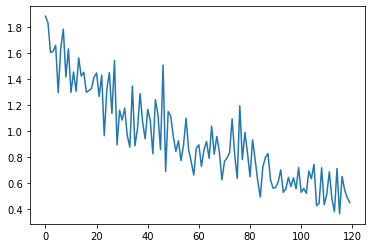

In [51]:
plt.plot(loss_arr)

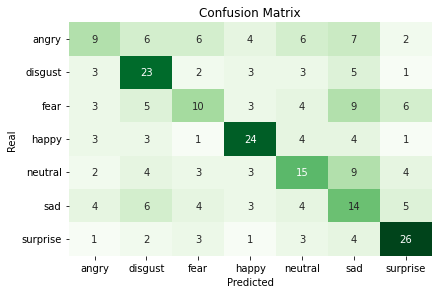

Sensitivity
43.21
Specificity
90.54
F1-score
42.46
Accuracy
43.21


In [54]:
torch.manual_seed(3)
test(alexnet)

## VGG19

In [55]:
x = list_img_224
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

tensor_y_train = torch.as_tensor(y_train)
tensor_y_test = torch.as_tensor(y_test)

batch_size = 64
data_train = MyDataset(x_train, tensor_y_train)
data_test = MyDataset(x_test, tensor_y_test)
train_loader = DataLoader(dataset=data_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=data_test, batch_size=batch_size, shuffle=False)

In [ ]:
vgg19 = torchvision.models.vgg19(pretrained=True)
for e in vgg19.parameters():
   e.requires_grad = False
vgg19.classifier[3] = nn.Linear(4096, 1024)
vgg19.classifier[6] = nn.Linear(1024, len(expressions))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
vgg19.to(device)

optimizer = optim.Adam(vgg19.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(alexnet.parameters(), lr=0.001, weight_decay = 0.005, momentum = 0.9)  

total_step = len(train_loader)

loss_arr = train(vgg19, optimizer, loss_fn, 20)

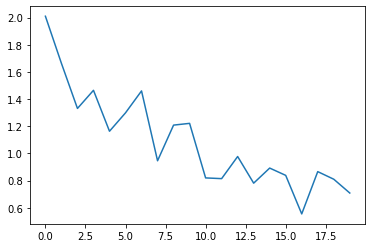

In [60]:
plt.plot(loss_arr)

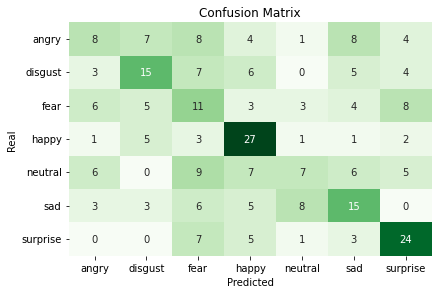

Sensitivity
38.21
Specificity
89.7
F1-score
36.92
Accuracy
38.21


In [61]:
torch.manual_seed(0)
test(vgg19)

## Resnet50

In [84]:
x = list_img_224
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

tensor_y_train = torch.as_tensor(y_train)
tensor_y_test = torch.as_tensor(y_test)

batch_size = 64
data_train = MyDataset(x_train, tensor_y_train)
data_test = MyDataset(x_test, tensor_y_test)
train_loader = DataLoader(dataset=data_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=data_test, batch_size=batch_size, shuffle=False)

In [86]:
resnet50 = torchvision.models.resnet50(pretrained=True)
for e in resnet50.parameters():
   e.requires_grad = False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# resnet50.fc = nn.Linear(in_features=2048, out_features=len(expressions), bias=True)
resnet50.fc = nn.Sequential(
         nn.Linear(2048, 1024),
         nn.ReLU(inplace=True),
         nn.Linear(1024, len(expressions)),
)
resnet50.to(device)
# Adaptar el classifier a las clases
optimizer = optim.Adam(resnet50.parameters(), lr=3e-4)
# optimizer = torch.optim.SGD(resnet50.parameters(), lr=0.01, weight_decay = 0.005, momentum = 0.9)  
total_step = len(train_loader)
loss_arr = train(resnet50, optimizer, loss_fn, 120)

Epoch [1/100], Loss: 1.9491
Epoch [2/100], Loss: 1.9585
Epoch [3/100], Loss: 1.9418
Epoch [4/100], Loss: 1.9240
Epoch [5/100], Loss: 1.9381
Epoch [6/100], Loss: 1.9514
Epoch [7/100], Loss: 1.9663
Epoch [8/100], Loss: 1.9399
Epoch [9/100], Loss: 1.9226
Epoch [10/100], Loss: 1.9368
Epoch [11/100], Loss: 1.9360
Epoch [12/100], Loss: 1.9202
Epoch [13/100], Loss: 1.9388
Epoch [14/100], Loss: 1.9385
Epoch [15/100], Loss: 1.9585
Epoch [16/100], Loss: 1.9264
Epoch [17/100], Loss: 1.9676
Epoch [18/100], Loss: 1.9310
Epoch [19/100], Loss: 1.9364
Epoch [20/100], Loss: 1.9295
Epoch [21/100], Loss: 1.9253
Epoch [22/100], Loss: 1.9132
Epoch [23/100], Loss: 1.9060
Epoch [24/100], Loss: 1.9340
Epoch [25/100], Loss: 1.8983
Epoch [26/100], Loss: 1.8741
Epoch [27/100], Loss: 1.8984
Epoch [28/100], Loss: 1.9023
Epoch [29/100], Loss: 1.8985
Epoch [30/100], Loss: 1.9245
Epoch [31/100], Loss: 1.8880
Epoch [32/100], Loss: 1.8732
Epoch [33/100], Loss: 1.8805
Epoch [34/100], Loss: 1.8936
Epoch [35/100], Loss: 1

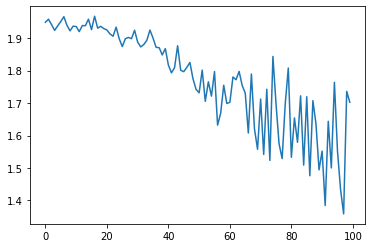

In [87]:
plt.plot(loss_arr)

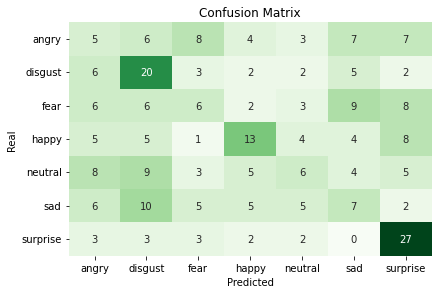

Sensitivity
30.0
Specificity
88.33
F1-score
28.21
Accuracy
30.0


In [88]:
torch.manual_seed(0)
test(resnet50)

## Resnet101

In [35]:
x = list_img_224
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

tensor_y_train = torch.as_tensor(y_train)
tensor_y_test = torch.as_tensor(y_test)

batch_size = 64
data_train = MyDataset(x_train, tensor_y_train)
data_test = MyDataset(x_test, tensor_y_test)
train_loader = DataLoader(dataset=data_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=data_test, batch_size=batch_size, shuffle=False)

In [42]:
resnet101 = torchvision.models.resnet101(pretrained=True)
for e in resnet101.parameters():
   e.requires_grad = False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# resnet101.fc = nn.Linear(in_features=2048, out_features=len(expressions), bias=True)
resnet101.fc = nn.Sequential(
         nn.Linear(2048, 1024),
         nn.ReLU(inplace=True),
         nn.Linear(1024, len(expressions)),
)
resnet101.to(device)
# resnet101
# Adaptar el classifier a las clases
optimizer = optim.Adam(resnet101.parameters(), lr=3e-4)
# optimizer = optim.SGD(resnet101.parameters(), lr=0.005, weight_decay=0.005, momentum=0.9)
total_step = len(train_loader)
loss_arr = train(resnet101, optimizer, loss_fn, 50)

c:\Users\Diego\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Diego\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50], Loss: 1.9346
Epoch [2/50], Loss: 1.8626
Epoch [3/50], Loss: 1.7572
Epoch [4/50], Loss: 1.6534
Epoch [5/50], Loss: 1.5173
Epoch [6/50], Loss: 1.4860
Epoch [7/50], Loss: 1.4564
Epoch [8/50], Loss: 1.5093
Epoch [9/50], Loss: 1.3891
Epoch [10/50], Loss: 1.4986
Epoch [11/50], Loss: 1.4144
Epoch [12/50], Loss: 1.1623
Epoch [13/50], Loss: 1.1864
Epoch [14/50], Loss: 1.5439
Epoch [15/50], Loss: 1.4630
Epoch [16/50], Loss: 1.3522
Epoch [17/50], Loss: 1.0770
Epoch [18/50], Loss: 1.2917
Epoch [19/50], Loss: 1.0969
Epoch [20/50], Loss: 1.1728
Epoch [21/50], Loss: 0.7609
Epoch [22/50], Loss: 0.9345
Epoch [23/50], Loss: 1.0111
Epoch [24/50], Loss: 0.9445
Epoch [25/50], Loss: 1.1058
Epoch [26/50], Loss: 1.0222
Epoch [27/50], Loss: 1.2445
Epoch [28/50], Loss: 0.8160
Epoch [29/50], Loss: 1.0716
Epoch [30/50], Loss: 0.9277
Epoch [31/50], Loss: 0.8922
Epoch [32/50], Loss: 1.1352
Epoch [33/50], Loss: 0.8353
Epoch [34/50], Loss: 0.9232
Epoch [35/50], Loss: 0.9928
Epoch [36/50], Loss: 1.0682
E

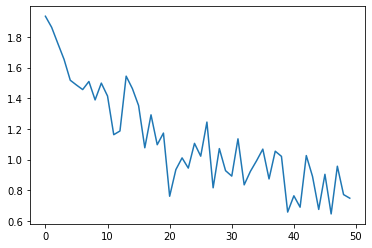

In [43]:
plt.plot(loss_arr)

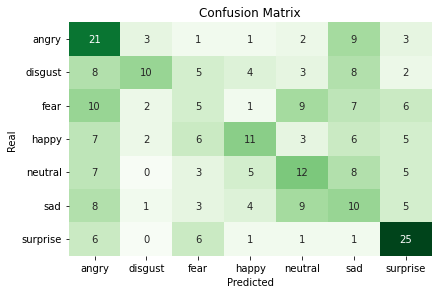

Sensitivity
33.57
Specificity
88.93
F1-score
32.69
Accuracy
33.57


In [48]:
torch.manual_seed(0)
test(resnet101)